In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

import os
import json
import copy

!pip install -q joblib
import joblib

!pip install -q holidays
import holidays

!pip install -q meteostat
from meteostat import Point, Daily

In [2]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [3]:
corDefault = "#6688AA"
corViridis = ['#440154', '#414487', '#2a788e', '#22a884', '#7ad151']
colorss = ['#b2c3d4', '#414487', '#B01756']

def set_plot_style():
    # Background colors
    plt.figure().patch.set_facecolor("0.85")
    plt.axes().set(facecolor="0.85")
    
    # Hiding grid
    plt.grid(False)
    
    # Setting only left and bottom spines as visible
    ax = plt.gca()
    ax.spines['bottom'].set_visible(True)
    ax.spines['left'].set_visible(True)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Spines color
    ax.spines['bottom'].set_color("black")
    ax.spines['left'].set_color("black")
    
    # Plot size
    plt.gcf().set_size_inches(6, 5)

    # Plot Style
    plt.style.use('seaborn-v0_8-colorblind')

# **LOADING MODEL**

In [5]:
model = joblib.load("../models/model_v2.pkl")

In [6]:
features = ["sell_value",
            "sell_quantity_lag_7",
            "rolling_std_sell_value",
            "daily_balance",
            "inventory_turnover",
            "buy_quantity",
            "inventory_lag_1",
            "precipitation",
            "incc_monthly_change",
            "fuel_price_lag_60",
            "is_weekend",
            "days_until_holiday",
            "month",
            "no_rain",
            "turnover_bin",
            "lag_7_bin"
]

# **FETCHING CONTEXT FEATURES**

The goal of this pricing model is to be executed automatically whenever a new purchase of the product is registered. This allows sales teams to receive optimized pricing recommendations in real time.

To simulate this behavior, we define a `purchase_date` (in this case, 2025-05-21) representing the most recent procurement event.

We then call the function `generate_context_features(purchase_date)`, which returns a one-row DataFrame with all the features required for the model prediction. These features are built automatically by:
- Accessing external APIs for **weather** and **holiday data**;
- Scraping public sources for **INCC (construction inflation)** and **fuel price**;
- Loading historical **sell and buy records** exported from the ERP's SQL database.

The resulting feature vector includes the following variables:
`sell_value`, `sell_quantity_lag_7`, `rolling_std_sell_value`, `daily_balance`, `inventory_turnover`, `buy_quantity`, `inventory_lag_1`, `precipitation`, `incc_monthly_change`, `fuel_price_vs_buy_value`, `is_weekend`, `days_until_holiday`, `month`, `turnover_bin`, and `lag_7_bin`.

This feature vector will be used in the next step to simulate profit under different pricing strategies.

In [9]:
purchase_date = datetime(2025, 5, 21)

In [10]:
def holiday_data(df, purchase_date):
    df['is_holiday'] = df['date'].apply(lambda x: 1 if x in holidays.Brazil(state = 'SP') else 0)
    df.loc[df['date'] == '2024-08-01', 'is_holiday'] = 1
    
    k = 1
    df.loc[0, 'days_until_holiday'] = 0
    
    for i in range(1, len(df)):
        if (df.loc[i, 'is_holiday'] == 1):
            h = df.loc[i, 'date']
    
            for j in range(k, i):
                df.loc[j, 'days_until_holiday'] = abs((h - df.loc[j, 'date']).days)
    
            k = i + 1
    
    df['days_until_holiday'] = df['days_until_holiday'].fillna(0).astype(int)
    df = df.drop('is_holiday', axis = 1)
    
    
    # Creating 'is_weekend' and 'month' features
    df['month'] = df['date'].dt.month
    df['is_weekend'] = df['date'].dt.dayofweek
    df['is_weekend'] = df['is_weekend'].apply(lambda x: True if x > 4 else False)
    
    
    # Filtering dataframe
    return df[df['date'] <= purchase_date]

In [11]:
def precipitation_data(purchase_date):
    city = Point(-22.31553, -49.070822)
    city.radius = 120000
    start_date = datetime(2024, 1, 1)
    end_date = purchase_date
    
    df = Daily(city, start_date, end_date)
    df = df.fetch()[['prcp']].fillna(0)
    df = df.rename_axis('date').reset_index()
    df = df.rename(columns = {'prcp': 'precipitation'})

    df['no_rain'] = (df['precipitation'] > 0.1).astype(int)

    return df

In [12]:
def incc_data(purchase_date):
    url = "https://www.dadosdemercado.com.br/indices/incc-di"
    i = pd.read_html(url)
    incc_df = i[0].copy()
    incc_df = incc_df.rename(columns = {'Unnamed: 0': 'Year', 'Fev': 'Feb', 'Abr': 'Apr', 'Mai': 'May', 'Ago': 'Aug', 'Set': 'Sep', 'Out': 'Oct', 'Dez': 'Dec'})
    incc_df = incc_df.set_index('Year')
    
    incc_df = incc_df.reset_index().melt(id_vars = 'Year', 
                                         value_vars = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'],
                                         var_name = 'Month', 
                                         value_name = 'incc')
    
    month_map = {'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6, 'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12}
    incc_df['Month'] = incc_df['Month'].map(month_map)
    incc_df['date'] = pd.to_datetime(dict(year = incc_df['Year'], month = incc_df['Month'], day = 1))
    
    incc_df['date'] = pd.to_datetime(incc_df['date'])
    incc_df = incc_df.sort_values(by = 'date')
    
    incc_df = incc_df.drop(columns = {'Year', 'Month'})
    incc_df = incc_df[(incc_df['date'] >= '2024-01-01') & (incc_df['date'] < purchase_date)].reset_index(drop = True)
    
    incc_df['incc'] = incc_df['incc'].str.replace('%', '', regex = False).str.replace(',', '.', regex = False)
    incc_df['incc'] = incc_df['incc'].astype(float)
    incc_df['incc'] = incc_df['incc'] / 100
    
    i = pd.DataFrame([{
        'date': purchase_date + timedelta(days = 1),
        'incc': np.nan
    }])
    incc_df = pd.concat([incc_df, i], ignore_index = True)
    incc_df = incc_df.set_index('date')
    incc_df = incc_df.asfreq('D', method = 'ffill')
    incc_df = incc_df.rename_axis('date').reset_index()

    incc_df['incc_monthly_change'] = incc_df['incc'] - incc_df['incc'].shift(30)
    incc_df = incc_df.drop('incc', axis = 1)
    
    return incc_df

In [13]:
def fuel_data():
    url = "https://www.gov.br/anp/pt-br/assuntos/precos-e-defesa-da-concorrencia/precos/precos-revenda-e-de-distribuicao-combustiveis/shlp/semanal/semanal-estados-desde-2013.xlsx"
    fuel_df = pd.read_excel(url)
    
    i = fuel_df[fuel_df.iloc[:, 0].astype(str).str.contains("DATA INICIAL", case = False, na = False)].index[0]
    fuel_df = fuel_df[i:len(fuel_df)].copy()
    fuel_df.columns = fuel_df.iloc[0]
    fuel_df = fuel_df.drop(fuel_df.index[0]).reset_index(drop = True)
    
    fuel_df = fuel_df[(fuel_df['ESTADO'] == 'SAO PAULO') & (fuel_df['PRODUTO'] == 'OLEO DIESEL S10')][['DATA INICIAL', 'PREÇO MÉDIO REVENDA']].copy().reset_index(drop = True)\
                        .rename(columns = {'DATA INICIAL': 'date', 'PREÇO MÉDIO REVENDA': 'fuel_price'})
    
    fuel_df['date'] = pd.to_datetime(fuel_df['date'])
    fuel_df['fuel_price'] = fuel_df['fuel_price'].astype(float)
    
    fuel_df = fuel_df.set_index('date')
    fuel_df = fuel_df.asfreq('D', method = 'ffill')
    fuel_df = fuel_df.rename_axis('date').reset_index()

    fuel_df['fuel_price_lag_60'] = fuel_df['fuel_price'].shift(60)
    
    return fuel_df

In [14]:
def sell_data():
    sell_df = pd.read_csv("../data/sql_exports/sell_records.csv")
    sell_df['sell_date'] = pd.to_datetime(sell_df['sell_date']).dt.normalize()
    sell_df = sell_df.rename(columns = {'sell_date': 'date'})
    sell_df = sell_df.groupby('date').agg({'sell_quantity': 'sum', 'sell_value': 'mean'}).reset_index()
    sell_df['sell_value'] = np.round(sell_df['sell_value'], 2)
    
    sell_df = sell_df[sell_df['sell_value'] > 25]
    sell_df = sell_df[sell_df['sell_quantity'] < 1000]
    
    sell_df['sell_quantity_lag_7'] = sell_df['sell_quantity'].shift(7)
    sell_df['rolling_std_sell_value'] = sell_df['sell_value'].rolling(window = 3).std()
    sell_df['lag_7_bin'] = pd.qcut(sell_df['sell_quantity_lag_7'], q = 4, labels = [0, 1, 2, 3]).fillna(0).astype(int)

    return sell_df

In [15]:
def buy_data():
    buy_df = pd.read_csv("../data/sql_exports/buy_records.csv")
    buy_df['buy_date'] = pd.to_datetime(buy_df['buy_date']).dt.normalize()
    buy_df = buy_df.rename(columns = {'buy_date': 'date'})
    buy_df = buy_df.groupby('date').agg({'buy_quantity': 'sum', 'buy_value': 'mean'}).reset_index()
    buy_df['buy_value'] = np.round(buy_df['buy_value'], 2)

    return buy_df

In [16]:
def inventory_data(purchase_date, sell_df, buy_df):
    inventory_df = pd.read_csv("../data/sql_exports/inventory_records.csv")
    inventory_df['date_inventory'] = pd.to_datetime(inventory_df['date_inventory']).dt.normalize()
    inventory_df = inventory_df.rename(columns = {'inventory': 'stock_count'})
    
    inventory_df.loc[0, 'date_inventory'] = '2024-01-01'
    i = pd.DataFrame([[purchase_date + timedelta(days = 1), 0]], columns = ['date_inventory', 'stock_count'])
    inventory_df = pd.concat([inventory_df, i], ignore_index = True)
    
    inventory_df['date_inventory'] = pd.to_datetime(inventory_df['date_inventory'])
    inventory_df = inventory_df.set_index('date_inventory')
    inventory_df = inventory_df.asfreq('D', fill_value = 0)
    
    inventory_df = inventory_df.rename_axis('date').reset_index()
    
    initial_inv = inventory_df.loc[0, 'stock_count']
    
    inventory_df = inventory_df.merge(sell_df[['date', 'sell_quantity']], on = 'date', how = 'left').fillna(0)
    inventory_df = inventory_df.merge(buy_df[['date', 'buy_quantity']], on = 'date', how = 'left').fillna(0)
    
    inventory_df['daily_balance'] = inventory_df['buy_quantity'] - inventory_df['sell_quantity']
    inventory_df.loc[0, 'inventory'] = initial_inv
    
    for i in range(1, len(inventory_df)):
        if (inventory_df.loc[i, 'stock_count'] == 0):
            inventory_df.loc[i, 'inventory'] = inventory_df.loc[i-1, 'inventory'] + inventory_df.loc[i, 'daily_balance']
        else:
            inventory_df.loc[i, 'inv_correction'] = inventory_df.loc[i-1, 'inventory'] + inventory_df.loc[i, 'daily_balance'] - inventory_df.loc[i, 'stock_count']
            inventory_df.loc[i, 'inventory'] = inventory_df.loc[i, 'stock_count']
        
    inventory_df['inv_correction'] = inventory_df['inv_correction'].fillna(0)

    inventory_df['inventory_lag_1'] = inventory_df['inventory'].shift(1)
    inventory_df['inventory_turnover'] = inventory_df['sell_quantity'] / (inventory_df['inventory_lag_1'] + 1e-6)
    inventory_df['turnover_bin'] = pd.qcut(inventory_df['inventory_turnover'], q = 4, labels = [0, 1, 2 ,3]).fillna(0).astype(int)

    inventory_df = inventory_df.drop(columns = {'stock_count', 'sell_quantity', 'buy_quantity', 'inv_correction'}, axis = 1)
    
    return inventory_df

In [17]:
def generate_context_features(purchase_date):
    # Creating base dataframe
    df = pd.date_range(start = '2024-01-01', end = (purchase_date + timedelta(days = 180)), freq = 'D')
    df = pd.DataFrame({'date': df})
    
    
    # Getting holidays and creating 'days_until_holiday' feature
    df = holiday_data(df, purchase_date)
    
    
    # Fetching precipitation data
    weather_df = precipitation_data(purchase_date)
    df = df.merge(weather_df, on = 'date', how = 'left')
    
    
    # Fetching INCC data and creating 'incc_monthly_change' feature
    incc_df = incc_data(purchase_date)
    df = df.merge(incc_df, on = 'date', how = 'left')
    
    
    # Fetching fuel price data and creating 'fuel_price_lag_60' feature 
    fuel_df = fuel_data()
    df = df.merge(fuel_df, on = 'date', how = 'left')
    
    
    # Fetching sell records data from exported SQL Database and creating 'sell_quantity_lag_7', 'rolling_std_sell_value', and 'lag_7_bin' features
    sell_df = sell_data()

    df = df.merge(sell_df, on = 'date', how = 'left')
    
    
    # Fetching buy records data from exported SQL Database
    buy_df = buy_data()
    
    df = df.merge(buy_df, on = 'date', how = 'left')
    
    
    # Fetching inventory records data from exported SQL Database and creating 'inventory_lag_1', 'inventory_turnover', and 'turnover_bin' features
    inventory_df = inventory_data(purchase_date, sell_df, buy_df)
    df = df.merge(inventory_df, on = 'date', how = 'left')


    # Filtering context vector
    df = df[df['date'] == purchase_date][features].reset_index(drop = True).copy()

    df['daily_balance'] = df['daily_balance'].astype(int)
    df['days_until_holiday'] = df['days_until_holiday'].astype(float)
    
    
    return df

In [18]:
context = generate_context_features(purchase_date)
context

,sell_value,sell_quantity_lag_7,rolling_std_sell_value,daily_balance,inventory_turnover,buy_quantity,inventory_lag_1,precipitation,incc_monthly_change,fuel_price_lag_60,is_weekend,days_until_holiday,month,no_rain,turnover_bin,lag_7_bin
0,38.15,154.0,1.824427,263,0.527778,320.0,108.0,0.0,0.0006,6.46,False,49.0,5,0,3,2.0


# **SIMULATING PROFIT ACROSS SELL PRICE RANGE**

In this section, we simulate the relationship between sell price, predicted demand, and resulting profit in order to identify the optimal selling price that maximizes revenue without compromising sales volume.

**METHODOLOGY:**
- Based on the defined `purchase_date`, we retrieve the corresponding **buy price** of the product from the ERP database;
- A reference `sell_price` is provided by the user to define the central point of the analysis (e.g., 39.90 BLR, the current selling price);
- A `price_range` is constructed from `sell_price - 15` to `sell_price + 5`, using increments of 0.05 BLR;
- For each price within that range:
    - The model predicts the expected demand;
    - The expected profit is calculated using:  
        `profit = (sell_price - buy_price) * predicted_quantity`
    - The results are stored and analyzed to identify the **optimal sell price**: the price at which the predicted profit is maximized without significant loss in volume.

This methodology enables the application of demand-aware pricing logic, supporting commercial decisions with machine learning predictions.

In [36]:
i = buy_data()
buy_price = i[i['date'] == purchase_date]['buy_value'].values[0]

In [38]:
sell_price = 39.9

In [40]:
def simulate_profit(sell_price, context_features, model, buy_price):
    input_features = context_features.copy()
    input_features['sell_value'] = sell_price

    predicted_quantity = np.expm1(model.predict(input_features.values)[0]).astype(int)
    profit = (sell_price - buy_price) * predicted_quantity
    
    return profit, predicted_quantity

In [42]:
price_range = np.arange(sell_price - 15, sell_price + 5, 0.05)

profits = []
demands = []
prices = []

for price in price_range:
    p, d = simulate_profit(price, context, model, buy_price)
    if (p > 0):
        profits.append(p)
        demands.append(d)
        prices.append(price)

In [44]:
optimal_price = prices[np.argmax(profits)]
optimal_profit = max(profits)
optimal_demand = demands[np.argmax(profits)]
profit_per_unit = optimal_profit / optimal_demand

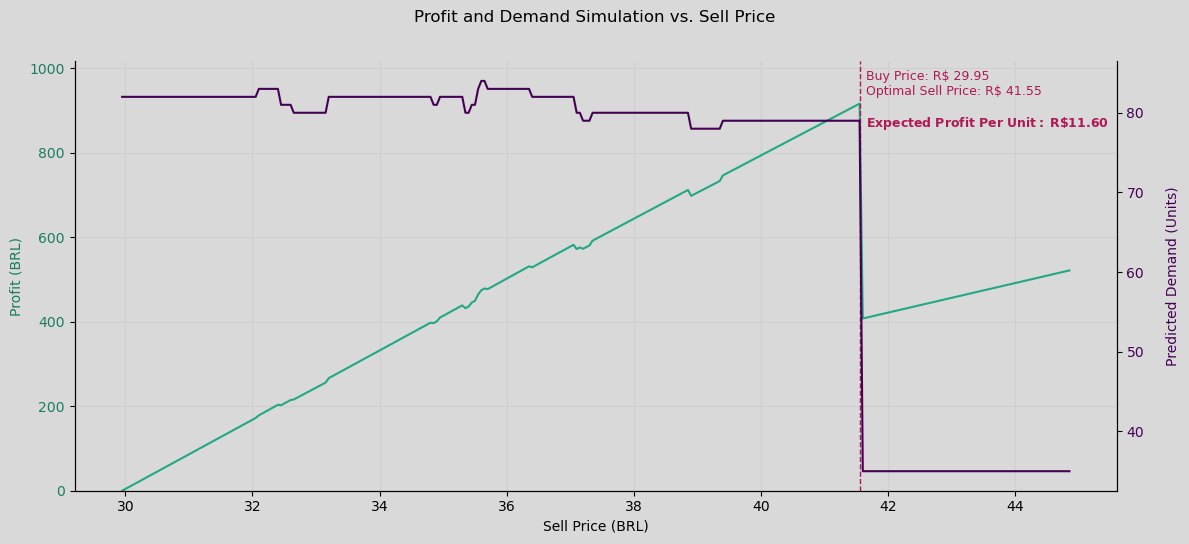

In [46]:
fig, ax = plt.subplots(figsize = (12, 5.5))
fig.patch.set_facecolor("0.85")

# Profit
ax.grid(visible = True, color = '0.81')
ax.set_xlabel('Sell Price (BRL)')
ax.set_ylabel('Profit (BRL)', color = '#197d60')
ax.plot(prices, profits, color = corViridis[3])
ax.tick_params(axis = 'y', labelcolor = '#197d60')
ax.set_facecolor("0.85")
ax.spines.top.set_visible(False)
ax.set_ylim(0,max(profits)+100)


# Optimal Price
ax.axvline(x = optimal_price, color = colorss[2], linestyle = '--', linewidth = 1)
ax.text(
    optimal_price + 0.1,
    ax.get_ylim()[1] * 0.98,
    f"Buy Price: R$ {buy_price:.2f}"\
    f"\nOptimal Sell Price: R$ {optimal_price:.2f}"\
    f"\n\n" + r"$\bf{Expected\ Profit\ Per\ Unit:\ R\$" + f"{profit_per_unit:.2f}" + r"}$",
    color = colorss[2],
    fontsize = 9,
    va = 'top'
)


# Demand
ax2 = ax.twinx()
ax2.set_ylabel('\nPredicted Demand (Units)', color = corViridis[0])
ax2.plot(prices, demands, color = corViridis[0])
ax2.tick_params(axis = 'y', labelcolor = corViridis[0])
ax2.set_facecolor("0.85")
ax2.spines.top.set_visible(False)


fig.suptitle('Profit and Demand Simulation vs. Sell Price\n')
fig.tight_layout()
plt.savefig("../visuals/48.ProfitAndDemandSimulationvSellPrice.svg")
plt.show()
plt.close()

# **CONCLUSION AND NEXT STEPS**

The simulation results reveal that the optimal sell price that maximizes profit, while preserving realistic demand levels, is approximately 41.55 BLR. Which is higher than the currently practiced price of 39.90 BLR. At this price point, the model estimates an expected **profit per unit of 11.60 BLR**, indicating significant room for margin optimization.

This reinforces the value of integrating machine learning into pricing workflows, particularly when demand forecasting models are enriched by internal operations data (e.g., purchases, inventory, and sales history) and external signals (e.g., inflation, weather, seasonality).

With the current v2 demand forecasting model finalized, the next steps focus on operationalizing and evolving the pricing layer:
- **A/B testing**: between v2 and the frozen v1 baseline, integrated into a real-world pricing workflow;
- **Monthly forecast evaluation and pricing refresh**: using recent demand data to detect drift or degradation in model accuracy;
- **Simulation of 30-day profit windows**: applying fixed-price scenarios to support bulk negotiations or promotional planning;
- **Tracking of profit per unit**: to balance total profit with operational efficiency and margin quality;
- **Weekly data collection routine**: of local competitor pricing, including both regional stores and leading suppliers in the area. This will allow the model and profit simulation logic to be stress-tested against real-world pricing pressure and to incorporate competitive price constraints in future iterations.

The system is now ready to be deployed as a dynamic pricing assistant providing actionable recommendations to optimize profitability, backed by continuously updated demand insights.

# **AUTHOR**

## Fábio Galdino